Omega_m: 0.31973340628583885
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts h

/tmp/ipykernel_2011372/2633647046.py:260: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.90, 0.96])


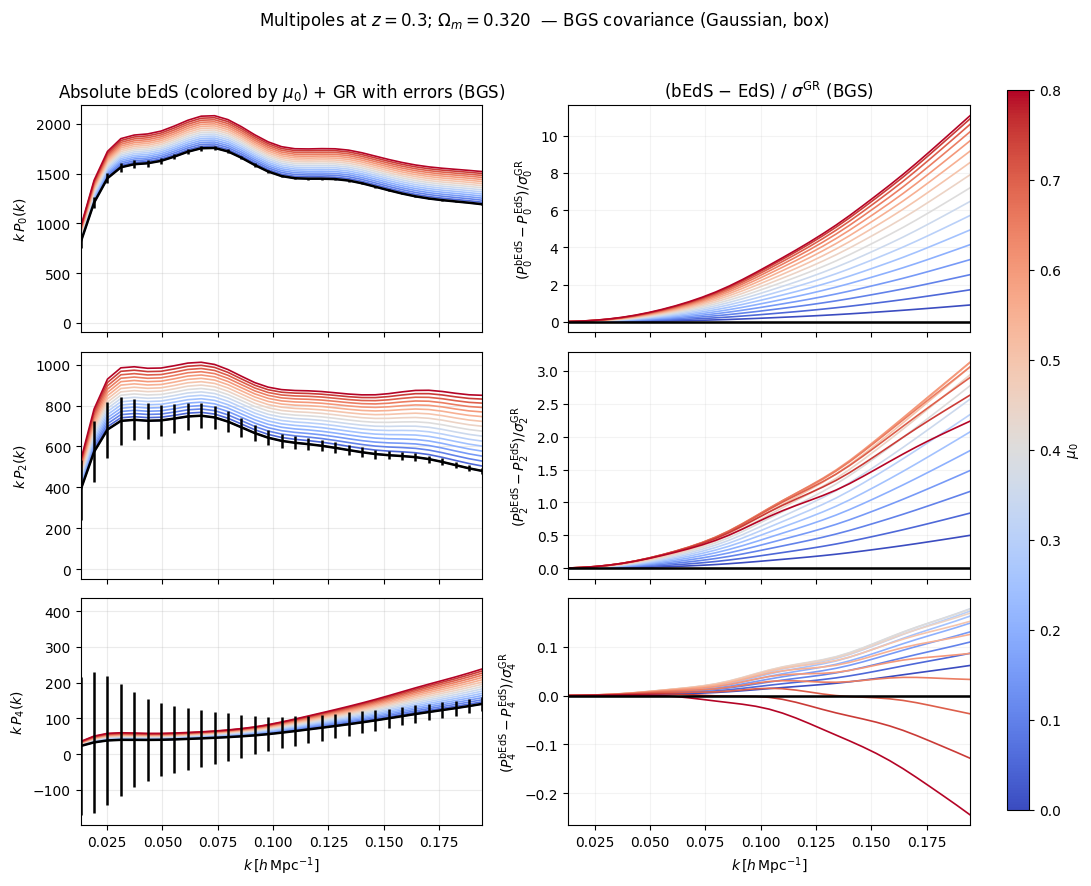

In [1]:
# 3×2 figure:
# col 0: absolute beyond-EdS multipoles (colored by μ0) + GR in black WITH ERROR BARS
# col 1: significance = (bEdS − EdS) / σ_GR per multipole (colored by μ0) + GR (zero line) in black

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy

# ---- pyfkpt (new fkpt wrapper) ----
import pyfkpt.rsd as pyfkpt

# ---- ISiTGR ----
import isitgr
from isitgr import model

# ---- thecov (Gaussian covariances of P_ell) ----
from thecov import geometry, covariance

# ==========================
# Configuration
# ==========================
h      = 0.6711
ombh2  = 0.022
omch2  = 0.122
omnuh2 = 0.0
As     = 2e-9
ns     = 0.965
z_pk   = 0.3

Om     = (ombh2 + omch2 + omnuh2) / (h**2)
print("Omega_m:", Om)

KMAX = 0.3
CAMB_KMAX = max(2.0, 16.0 * KMAX) * 1.25

# nuisance / bias
b1 = 1.70
b2 = -0.45
bs2  = -4/7*(b1 - 1)
b3nl = 32/315*(b1 - 1)
alpha0, alpha2, alpha4, ctilde = 3.0, -29.0, 0.0, 0.0
alpha0shot, alpha2shot, pshotp = 0.08, -8.0, 5000.0
nuis = [b1,b2,bs2,b3nl,alpha0,alpha2,alpha4,ctilde,alpha0shot,alpha2shot,pshotp]

# μ0 sweep (include GR=0)
mu0_vals = np.linspace(0.0, 0.8, 17)

# BGS tracer settings for covariance
BGS_nbar   = 5.0e-4          # (h/Mpc)^3
BGS_volume = 2000.0**3       # (Mpc/h)^3   (i.e., (2 Gpc/h)^3 box)

# k-range to display / use for σ
KMIN_MASK = 0.01
KMAX_MASK = 0.20

base_common = dict(
    z=z_pk, Om=Om, h=h,
    b1=b1, b2=b2, bs2=bs2, b3nl=b3nl,
    alpha0=alpha0, alpha2=alpha2, alpha4=alpha4, ctilde=ctilde,
    PshotP=pshotp, alpha0shot=alpha0shot, alpha2shot=alpha2shot,
    nquadSteps=300, chatty=0,
    model="HDKI",
    mg_variant="mu_OmDE",
)

# ==========================
# Helper: return EdS & bEdS multipoles for given μ0
# ==========================
def compute_multipoles_pair(mu0):
    # ---- ISiTGR params ----
    pars = isitgr.CAMBparams()
    pars.set_cosmology(H0=h*100, ombh2=ombh2, omch2=omch2, mnu=93.14*omnuh2,
                       MG_parameterization="muSigma", mu0=mu0)
    pars.InitPower.set_params(As=As, ns=ns)

    # build a *local guarded* pad around z_pk so the central window always fits
    z_pad = model.redshift_padding(z_pk)

    # run once on the pad
    pars.set_matter_power(redshifts=z_pad, kmax=CAMB_KMAX)
    pars.NonLinear = model.NonLinear_none
    results = isitgr.get_results(pars)

    # linear P(k) and f(k) at zeff=z_pk
    PK, _, ks = results.get_matter_power_interpolator(
        nonlinear=False, hubble_units=True, k_hunit=True, return_z_k=True, silent=True
    )
    pk_lin = PK.P(z_pk, ks)

    ks_fk, fzk = results.get_growth_rate(z_pk)
    fk_lin = fzk[0]                    # (Nk,)
    assert np.allclose(ks_fk, ks)      # same k-grid

    # cut to analysis k-range
    mask   = ks <= KMAX
    ks_cut = ks[mask]
    pk_cut = pk_lin[mask]
    fk_cut = fk_lin[mask]

    # small-k average for f0 (for tables that want a single number)
    smallk = ks_cut < 3e-3
    f0 = float(np.mean(fk_cut[smallk])) if np.any(smallk) else float(fk_cut[0])

    # FKPT evaluation grid
    base = dict(
        **base_common,
        mu0=mu0,
        kmin=float(max(1e-3, ks_cut.min())),
        kmax=float(min(ks_cut.max(), KMAX)),
        Nk=int(min(ks_cut.size, 50)),
    )
    k_eval = np.linspace(base["kmin"], base["kmax"], base["Nk"])

    # EdS kernels
    pE = deepcopy(base); pE["rescale_PS"]=False; pE["use_beyond_eds_kernels"]=False
    tE = pyfkpt.compute_multipoles(k=ks_cut, pk=pk_cut, fk=fk_cut, f0=f0, **pE)
    kE, P0E, P2E, P4E = pyfkpt.rsd_multipoles(k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tE)

    # beyond-EdS kernels
    pB = deepcopy(base); pB["rescale_PS"]=False; pB["use_beyond_eds_kernels"]=True
    tB = pyfkpt.compute_multipoles(k=ks_cut, pk=pk_cut, fk=fk_cut, f0=f0, **pB)
    kB, P0B, P2B, P4B = pyfkpt.rsd_multipoles(k=k_eval, nuis=nuis, z=z_pk, Om=Om, ap=False, tables=tB)

    assert np.allclose(kE, kB)
    return kB, (P0E, P2E, P4E), (P0B, P2B, P4B)

def interp_to_grid(k_src, y_src, k_target):
    # assumes k_src is increasing; if not, sort first
    return np.interp(k_target, k_src, y_src)

# ================= plot: 3×2 grid =================
plt.close('all')
fig, axes = plt.subplots(3, 2, figsize=(11, 9), sharex='col')
(ax0_abs, ax0_sig), (ax2_abs, ax2_sig), (ax4_abs, ax4_sig) = axes

# --- color map for μ0 sweep ---
cmap = plt.get_cmap('coolwarm')
norm = mpl.colors.Normalize(vmin=mu0_vals.min(), vmax=mu0_vals.max())
fig.subplots_adjust(right=0.90)
cax = fig.add_axes([0.92, 0.09, 0.02, 0.80])
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])

k_for_cov = None
P0E_GR = P2E_GR = P4E_GR = None
P0B_GR = P2B_GR = P4B_GR = None

# ---------- sweep over μ0 (first pass to cache GR & draw absolute curves) ----------
for mu0 in mu0_vals:
    k, (P0E, P2E, P4E), (P0B, P2B, P4B) = compute_multipoles_pair(mu0)
    color = cmap(norm(mu0))

    if mu0 == 0.0:
        k_for_cov = k.copy()
        P0E_GR, P2E_GR, P4E_GR = P0E.copy(), P2E.copy(), P4E.copy()
        P0B_GR, P2B_GR, P4B_GR = P0B.copy(), P2B.copy(), P4B.copy()

    # left column: absolute beyond-EdS k*Pℓ (colored by μ0)
    ax0_abs.plot(k, k*P0B, color=color, lw=1.2)
    ax2_abs.plot(k, k*P2B, color=color, lw=1.2)
    ax4_abs.plot(k, k*P4B, color=color, lw=1.2)

if k_for_cov is None:
    raise RuntimeError("No GR (mu0=0) case computed; can't build covariance.")

# ---------- build covariance from GR (BGS tracer) ----------
# Construct uniform edges from centers
Nk_full = k_for_cov.size
dk_full = (k_for_cov[-1] - k_for_cov[0]) / (Nk_full - 1)
kmin_edge_full = k_for_cov[0] - dk_full/2.0
kmax_edge_full = k_for_cov[-1] + dk_full/2.0

geom = geometry.BoxGeometry(volume=BGS_volume, nbar=BGS_nbar)
cov  = covariance.GaussianCovariance(geom)
cov.set_kbins(kmin=kmin_edge_full, kmax=kmax_edge_full, dk=dk_full)

# supply GR multipoles; mark monopole as including shot noise (since rsd_multipoles used shot-noise nuisances)
cov.set_galaxy_pk_multipole(P0B_GR, ell=0, has_shotnoise=True)
cov.set_galaxy_pk_multipole(P2B_GR, ell=2)
cov.set_galaxy_pk_multipole(P4B_GR, ell=4)
cov.compute_covariance()

# extract diagonal errors per multipole from the stacked covariance:
diag_full = np.sqrt(np.diag(cov.cov))
sig0_full = diag_full[0:Nk_full]
sig2_full = diag_full[Nk_full:2*Nk_full]
sig4_full = diag_full[2*Nk_full:3*Nk_full]

# ---------- apply k mask consistently ----------
mask_cov = (k_for_cov > KMIN_MASK) & (k_for_cov < KMAX_MASK)

k_for_cov = k_for_cov[mask_cov]
P0B_GR = P0B_GR[mask_cov]; P2B_GR = P2B_GR[mask_cov]; P4B_GR = P4B_GR[mask_cov]
P0E_GR = P0E_GR[mask_cov]; P2E_GR = P2E_GR[mask_cov]; P4E_GR = P4E_GR[mask_cov]
sig0_GR = sig0_full[mask_cov]; sig2_GR = sig2_full[mask_cov]; sig4_GR = sig4_full[mask_cov]

# ---------- overplot GR (black) with error bars on abs column ----------
ax0_abs.errorbar(k_for_cov, k_for_cov*P0B_GR, yerr=k_for_cov*sig0_GR, fmt='-', color='k', lw=1.8, capsize=0)
ax2_abs.errorbar(k_for_cov, k_for_cov*P2B_GR, yerr=k_for_cov*sig2_GR, fmt='-', color='k', lw=1.8, capsize=0)
ax4_abs.errorbar(k_for_cov, k_for_cov*P4B_GR, yerr=k_for_cov*sig4_GR, fmt='-', color='k', lw=1.8, capsize=0)

# ---------- recompute sweep to plot significance in right column (interpolate to masked cov grid) ----------
for mu0 in mu0_vals:
    k, (P0E, P2E, P4E), (P0B, P2B, P4B) = compute_multipoles_pair(mu0)
    color = cmap(norm(mu0))

    d0 = P0B - P0E
    d2 = P2B - P2E
    d4 = P4B - P4E

    d0_on_cov = interp_to_grid(k, d0, k_for_cov)
    d2_on_cov = interp_to_grid(k, d2, k_for_cov)
    d4_on_cov = interp_to_grid(k, d4, k_for_cov)

    s0 = d0_on_cov / sig0_GR
    s2 = d2_on_cov / sig2_GR
    s4 = d4_on_cov / sig4_GR

    ax0_sig.plot(k_for_cov, s0, color=color, lw=1.2)
    ax2_sig.plot(k_for_cov, s2, color=color, lw=1.2)
    ax4_sig.plot(k_for_cov, s4, color=color, lw=1.2)

# GR reference line (zero significance) in black
ax0_sig.plot(k_for_cov, np.zeros_like(k_for_cov), color='k', lw=1.8)
ax2_sig.plot(k_for_cov, np.zeros_like(k_for_cov), color='k', lw=1.8)
ax4_sig.plot(k_for_cov, np.zeros_like(k_for_cov), color='k', lw=1.8)

# ----- styling -----
# col 0: absolute (with GR + error bars); note y is k * P_ell
for ax, lab in zip([ax0_abs, ax2_abs, ax4_abs],
                   [r"$k\,P_0(k)$", r"$k\,P_2(k)$", r"$k\,P_4(k)$"]):
    ax.grid(True, alpha=0.25)
    ax.set_ylabel(lab)

# col 1: significance (bEdS − EdS)/σ_GR
for ax, lab in zip([ax0_sig, ax2_sig, ax4_sig],
                   [r"$(P_0^{\rm bEdS}-P_0^{\rm EdS})/\sigma_0^{\rm GR}$",
                    r"$(P_2^{\rm bEdS}-P_2^{\rm EdS})/\sigma_2^{\rm GR}$",
                    r"$(P_4^{\rm bEdS}-P_4^{\rm EdS})/\sigma_4^{\rm GR}$"]):
    ax.axhline(0, color='k', lw=1.0, alpha=0.5)
    ax.grid(True, alpha=0.15)
    ax.set_ylabel(lab)

# x limits & labels
for col in range(2):
    for ax in axes[:, col]:
        ax.set_xlim(k_for_cov[0], k_for_cov[-1])
for ax in axes[-1, :]:
    ax.set_xlabel(r"$k\,[h\,\mathrm{Mpc}^{-1}]$")

# titles
axes[0,0].set_title("Absolute bEdS (colored by $\\mu_0$) + GR with errors (BGS)", fontsize=12)
axes[0,1].set_title("(bEdS − EdS) / $\\sigma^{\\rm GR}$ (BGS)", fontsize=12)

# colorbar
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label(r'$\mu_0$')

fig.suptitle(fr"Multipoles at $z={z_pk}$; $\Omega_m={Om:.3f}$  — BGS covariance (Gaussian, box)", y=0.98)
plt.tight_layout(rect=[0, 0, 0.90, 0.96])
plt.show()